## Preprocessing version 5
### Details
this version 
- uses all data
- has validation split
- uses bert tokenizer
- does not train embedding

In [18]:
doc_name = "/tmp2/b05902064/train.article.txt"
summ_name = "/tmp2/b05902064/train.title.txt"
out_dir = "/tmp2/b05902064/"
vocab_name = out_dir+"vocab.json"
data_seq_name = out_dir+"train_seq.json"
valid_seq_name = out_dir+"valid_seq.json"
min_count = 7
num_threads = 8
corpus_size = 3803957
validation_split = 0.01

In [2]:
import os
import csv
import json
import numpy as np
# from nltk import word_tokenize as tokenize
from pytorch_pretrained_bert.tokenization import BertTokenizer
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from gensim.models.callbacks import CallbackAny2Vec

In [3]:
# !pip install --user pytorch_pretrained_bert
# !pip install --user gensim

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# "[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]"
UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

In [5]:
def getlines(name):
    total = !wc -l {name}
    return int(total[0].split()[0])

In [6]:
summaries = []
articles = []

# Reader = csv.reader(open(train_name, newline='', encoding='ISO-8859-1'), delimiter=',')
with open(doc_name, newline='', encoding='utf-8') as f:
    total = getlines(doc_name)
    for i,line in tqdm(enumerate(f), total=total):
        line = line.strip()
        line = line.replace('<unk>', UNK)
        articles.append(line)
with open(summ_name, newline='', encoding='utf-8') as f:
    total = getlines(summ_name)
    for i,line in tqdm(enumerate(f), total=total):
        line = line.strip()
        line = line.replace('<unk>', UNK)
        summaries.append(line)

In [7]:
summaries = summaries[:min(corpus_size, len(summaries))]
articles = articles[:min(corpus_size, len(summaries))]

In [8]:
data = []
if num_threads > 1:
    def task(s):
        return [BOS] + tokenizer.tokenize(s) + [EOS]
    
    with Pool(num_threads) as p:
        chunksize = 200
        summaries = list(tqdm(p.imap(task, summaries, chunksize=chunksize), total=len(summaries)))
        articles = list(tqdm(p.imap(task, articles, chunksize=chunksize), total=len(articles)))
    data = summaries+articles
else:
    for i, summ in tqdm(enumerate(summaries+articles), total=len(summaries+articles)):
        words = tokenize(summ)
        data.append(['<bos>'] + words + ['<eos>'])

In [9]:
num_summ = len(summaries)
index = 99999
print("[summary]", summaries[index])
print("[documen]", articles[index])

[summary] ['[CLS]', 'mother', 'teresa', 'in', 'fine', '[UNK]', 'says', 'doctor', '[SEP]']
[documen] ['[CLS]', 'mother', 'teresa', "'", 's', 'condition', 'had', 'greatly', 'improved', 'a', 'day', 'after', 'she', 'was', 'admitted', 'to', 'hospital', 'following', 'heart', 'failure', ',', 'a', 'doctor', 'attending', 'her', 'told', 'af', '##p', 'saturday', '.', '[SEP]']


In [13]:
print(len(tokenizer.vocab))
print(type(tokenizer.vocab))

30522
<class 'collections.OrderedDict'>


In [11]:
# print(tokenizer.basic_tokenizer.never_split)
tokens = tokenizer.tokenize(BOS+" I thought U would not split this. "+EOS)
idx = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(idx)

['[CLS]', 'i', 'thought', 'u', 'would', 'not', 'split', 'this', '.', '[SEP]']
[101, 1045, 2245, 1057, 2052, 2025, 3975, 2023, 1012, 102]


In [14]:
json.dump(tokenizer.vocab, open(vocab_name, "w"))

In [ ]:
seqdata = {'summary':[], 'document':[]}
valseqdata = {'summary':[], 'document':[]}

with Pool(num_threads) as p:
    chunksize = 200
    summ_seqs = list(tqdm(p.imap(tokenizer.convert_tokens_to_ids, summaries, chunksize=chunksize), total=num_summ))
    docu_seqs = list(tqdm(p.imap(tokenizer.convert_tokens_to_ids, articles, chunksize=chunksize), total=num_summ))

for i in range(num_summ):
    if i in val_set:
        valseqdata['summary'].append(summ_seqs[i])
        valseqdata['document'].append(docu_seqs[i])
    else:
        seqdata['summary'].append(summ_seqs[i])
        seqdata['document'].append(docu_seqs[i])

In [15]:
seqdata = {'summary':[], 'document':[]}
valseqdata = {'summary':[], 'document':[]}
# num_summ = len(data) / 2
val_set = np.random.randint(0, num_summ, size=int(validation_split*num_summ))
for i,words in tqdm(enumerate(summaries), total=num_summ):    
    seq = tokenizer.convert_tokens_to_ids(words)
    if i in val_set:
        valseqdata['summary'].append(seq)
    else:
        seqdata['summary'].append(seq)
for i,words in tqdm(enumerate(articles), total=num_summ):
    seq = tokenizer.convert_tokens_to_ids(words)
    if i in val_set:
        valseqdata['document'].append(seq)
    else:
        seqdata['document'].append(seq)
print(len(seqdata['document']), len(valseqdata['document']))


3766122 37835


In [19]:
json.dump(seqdata, open(data_seq_name, "w"))
json.dump(valseqdata, open(valid_seq_name, "w"))

In [20]:
lengths = []
key = 'document'
for doc in seqdata[key]:
    lens = len(doc)
    lengths.append(lens)

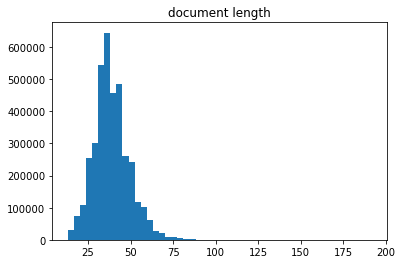

In [22]:
import matplotlib.pyplot as plt
plt.hist(lengths, 50)
plt.title(key +' length')
plt.show()